In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

In [12]:
base_path = Path('../experiments')

In [13]:
!ls ../experiments

bac_fixed_pendbac_2021-08-11   medium_start_2021-08-05
default_2021-08-05	       medium_start2_2021-08-05
default_2021-08-06	       random_cartpole_2021-08-06
default_2021-08-08	       random_init_11_2021-08-04
default_2021-08-09	       random_init_12_2021-08-04
default_2021-08-10	       random_init_12_2021-08-05
first_pendulum		       rollout_fixed_pendbac_test_2021-08-10
full_start_2021-08-05	       test_old_hp_12_2021-08-04
goddard_first_try	       test_old_hp_2021-08-04
long_cem_pendulum	       tight_start_2021-08-05
mbrl_fixed_pendbac_2021-08-11  working_pendulum1


In [14]:
paths = {# 'BAC (seed 12)': 'random_init_12_2021-08-05/10-02-01/',
         'Rollout BAC (fixed start)': 'rollout_fixed_pendbac_test_2021-08-10/21-08-52',
         'MBRL (fixed start)': 'mbrl_fixed_pendbac_2021-08-11/08-44-32',
         'Active BAC (fixed start)': 'bac_fixed_pendbac_2021-08-11/08-56-57',
        }

In [15]:
data = {}
for key, path in paths.items():
    info_path = base_path / path / 'info.pkl'
    with info_path.open('rb') as f:
        data[key] = pickle.load(f)

In [16]:
data['Active BAC (fixed start)']['Eval Returns']

[array([-856.90781165, -968.77137995, -860.02153596]),
 array([-871.15621294, -854.82463342, -887.89327402]),
 array([-125.78587384, -250.50088243, -125.98663404]),
 array([-126.56597873, -126.39133295, -125.96650234]),
 array([-125.8081935 , -125.76544938, -125.77079645]),
 array([-126.03992588, -126.10556316, -126.39783584]),
 array([-126.1770275 , -125.80819224, -125.98746939]),
 array([-126.2711719 , -125.75829562, -759.5419261 ]),
 array([-126.51598301, -997.04073631, -126.2298917 ]),
 array([-126.03010486, -125.87807287, -125.75611453]),
 array([-125.96145138, -125.86474401, -125.81485419]),
 array([-126.15009571, -126.12696355, -125.23838212])]

In [17]:
data = {}
for key, path in paths.items():
    info_path = base_path / path / 'info.pkl'
    with info_path.open('rb') as f:
        data[key] = pickle.load(f)

dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])
dict_keys(['GT Returns', 'Acquisition Function Value', 'Eval Returns', 'Eval ndata', 'Model MSE (current MPC)', 'Model MSE (random test set)', 'Model MSE (GT MPC)'])


Text(0.5, 0, 'Number of Queries')

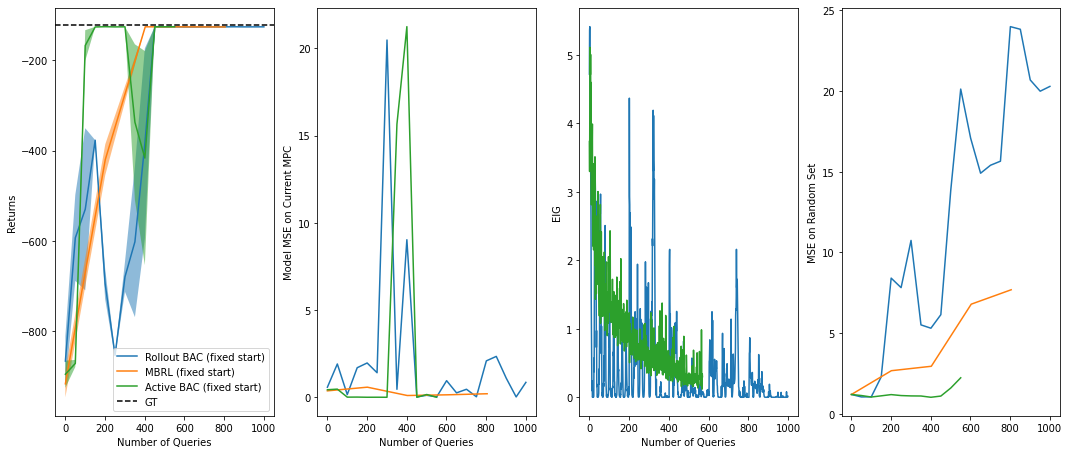

In [18]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(18, 7.5))
for key, vals in data.items():
    print(vals.keys())
    returns = np.array(vals['Eval Returns'])
    rmean = returns.mean(axis=1)
    rstderr = returns.std(axis=1) / np.sqrt(returns.shape[1])
    ndata = vals['Eval ndata']
    ax1.plot(ndata, rmean, label=key)
    ax1.fill_between(ndata, rmean - rstderr, rmean + rstderr, alpha=0.5)
    if 'Model MSE' in vals:
        mses = vals['Model MSE']
    else:
        mses = vals['Model MSE (current MPC)']
    ax2.plot(ndata, mses, label=key)
    if 'Acquisition Function Value' in vals:
        acqs = vals['Acquisition Function Value']
        ax3.plot(acqs, label=key)
    else:
        ax3.plot([], label=key)
    if 'Model MSE (random test set)' in vals:
        mses = vals['Model MSE (random test set)']
        ax4.plot(ndata, mses, label=key)
        
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Returns')
ax1.axhline(-122, color='black', linestyle='--', label='GT')
ax1.legend()
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Model MSE on Current MPC')
ax3.set_xlabel('Number of Queries')
ax3.set_ylabel('EIG')
ax4.set_ylabel("MSE on Random Set")
ax3.set_xlabel('Number of Queries')
